In [1]:
# MODIFY! 
# use RobustScaler! 
model_name = 'rf-no'

# Import Libraries & Data 

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
df = pd.read_csv('./data/d-no-ns.csv')
X = df.drop('throughput',axis=1)
y = df['throughput']

---

# Scale Data

In [4]:
# Split the data
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

# Scale the data
from sklearn.preprocessing import RobustScaler
scaler = RobustScaler()
scaler.fit(X_train)

RobustScaler()

In [5]:
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

# Determine Hyperparameters

## Determine Max Features

In [6]:
# MODIFY!
from sklearn.ensemble import RandomForestRegressor

model = RandomForestRegressor(warm_start=True)
model

RandomForestRegressor(warm_start=True)

In [7]:
p_grid = {
    'max_features':['auto', 'sqrt', 'log2']
}

In [8]:
from sklearn.model_selection import GridSearchCV

In [9]:
grid_model = GridSearchCV(
    estimator=model,
    param_grid =p_grid, 
    scoring='neg_mean_squared_error',
    cv=10, 
    verbose=1
)

In [10]:
grid_model.fit(X_train,y_train)

Fitting 10 folds for each of 3 candidates, totalling 30 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:   37.6s finished


GridSearchCV(cv=10, estimator=RandomForestRegressor(warm_start=True),
             param_grid={'max_features': ['auto', 'sqrt', 'log2']},
             scoring='neg_mean_squared_error', verbose=1)

In [11]:
grid_model.best_params_

{'max_features': 'auto'}

In [12]:
hp = pd.Series(name=f'{model_name} HP', data=grid_model.best_params_)

In [13]:
hp

max_features    auto
Name: rf-no HP, dtype: object

In [14]:
hp.to_csv(f'./hyperparameters/{model_name}.csv')

## Determine Number of Estimators

In [15]:
# MODIFY!
import time

estimators = [5,10,25,50,100,500,1000,2000]
scores_list = []

from sklearn.ensemble import RandomForestRegressor

for e in estimators: 
    start = time.time()
    print(f'Starting {e} estimators')
    score_model = RandomForestRegressor(
        n_estimators=e,
        max_features=grid_model.best_params_['max_features']
    )
    
    from sklearn.model_selection import cross_validate

    scores = cross_validate(
        score_model, 
        X_train, 
        y_train,
        scoring=[
            'neg_mean_absolute_error',
            'neg_mean_squared_error',
            'neg_root_mean_squared_error'
        ],
        cv=10
    )
    
    scores = pd.DataFrame(scores)
    scores
    mean_scores = scores.mean()
    scores_list.append(mean_scores)
    print(f'Done with {e} estimators')
    end = time.time()
    print(f'Elapsed time: {end - start}')
    print('\n')

Starting 5 estimators
Done with 5 estimators
Elapsed time: 1.7690539360046387


Starting 10 estimators
Done with 10 estimators
Elapsed time: 2.289903163909912


Starting 25 estimators
Done with 25 estimators
Elapsed time: 5.769585847854614


Starting 50 estimators
Done with 50 estimators
Elapsed time: 11.534534215927124


Starting 100 estimators
Done with 100 estimators
Elapsed time: 30.612385034561157


Starting 500 estimators
Done with 500 estimators
Elapsed time: 124.3610851764679


Starting 1000 estimators
Done with 1000 estimators
Elapsed time: 220.77700901031494


Starting 2000 estimators
Done with 2000 estimators
Elapsed time: 863.9045739173889




In [16]:
scores_df = pd.DataFrame(scores_list)

In [17]:
scores_df

,fit_time,score_time,test_neg_mean_absolute_error,test_neg_mean_squared_error,test_neg_root_mean_squared_error
0,0.171094,0.004069,-3.043054,-18.171000,-4.247393
1,0.223830,0.004277,-2.953408,-17.021798,-4.100414
2,0.569950,0.005599,-2.797186,-15.682247,-3.945593
3,1.140864,0.010636,-2.770126,-15.183979,-3.883175
4,3.023198,0.034863,-2.746151,-15.024164,-3.862763
5,12.347116,0.078061,-2.736286,-14.906599,-3.846315
6,21.884180,0.172201,-2.733538,-14.792618,-3.831847
7,84.609357,1.693021,-2.730631,-14.815535,-3.835199


In [18]:
scores_df['Est'] = estimators

In [19]:
scores_df

,fit_time,score_time,test_neg_mean_absolute_error,test_neg_mean_squared_error,test_neg_root_mean_squared_error,Est
0,0.171094,0.004069,-3.043054,-18.171000,-4.247393,5
1,0.223830,0.004277,-2.953408,-17.021798,-4.100414,10
2,0.569950,0.005599,-2.797186,-15.682247,-3.945593,25
3,1.140864,0.010636,-2.770126,-15.183979,-3.883175,50
4,3.023198,0.034863,-2.746151,-15.024164,-3.862763,100
5,12.347116,0.078061,-2.736286,-14.906599,-3.846315,500
6,21.884180,0.172201,-2.733538,-14.792618,-3.831847,1000
7,84.609357,1.693021,-2.730631,-14.815535,-3.835199,2000


# Export Scores for Number of Estimators

In [20]:
# mean_scores

In [21]:
scores_df = scores_df.rename(columns={
    'fit_time':'Fit Time',
    'score_time':'Score Time',
    'test_neg_mean_absolute_error':'MAE',
    'test_neg_mean_squared_error':'MSE',
    'test_neg_root_mean_squared_error':'RMSE'
})

In [22]:
scores_df

,Fit Time,Score Time,MAE,MSE,RMSE,Est
0,0.171094,0.004069,-3.043054,-18.171000,-4.247393,5
1,0.223830,0.004277,-2.953408,-17.021798,-4.100414,10
2,0.569950,0.005599,-2.797186,-15.682247,-3.945593,25
3,1.140864,0.010636,-2.770126,-15.183979,-3.883175,50
4,3.023198,0.034863,-2.746151,-15.024164,-3.862763,100
5,12.347116,0.078061,-2.736286,-14.906599,-3.846315,500
6,21.884180,0.172201,-2.733538,-14.792618,-3.831847,1000
7,84.609357,1.693021,-2.730631,-14.815535,-3.835199,2000


In [23]:
scores_df[['MAE','MSE','RMSE']] = scores_df[['MAE','MSE','RMSE']].apply(lambda x : abs(x))

In [24]:
scores_df
# we go for 25 estimations. Note that from 25 -> 50 estimations the error metrics worsen

,Fit Time,Score Time,MAE,MSE,RMSE,Est
0,0.171094,0.004069,3.043054,18.171000,4.247393,5
1,0.223830,0.004277,2.953408,17.021798,4.100414,10
2,0.569950,0.005599,2.797186,15.682247,3.945593,25
3,1.140864,0.010636,2.770126,15.183979,3.883175,50
4,3.023198,0.034863,2.746151,15.024164,3.862763,100
5,12.347116,0.078061,2.736286,14.906599,3.846315,500
6,21.884180,0.172201,2.733538,14.792618,3.831847,1000
7,84.609357,1.693021,2.730631,14.815535,3.835199,2000


In [25]:
scores_df.to_csv(f'./est-scores/{model_name}-est.csv')

In [26]:
pct_scores_df = scores_df.pct_change()

In [27]:
pct_scores_df

,Fit Time,Score Time,MAE,MSE,RMSE,Est
0,NaN,NaN,NaN,NaN,NaN,NaN
1,0.308224,0.050918,-0.029459,-0.063244,-0.034605,1.0
2,1.546357,0.309172,-0.052895,-0.078696,-0.037757,1.5
3,1.001690,0.899597,-0.009674,-0.031773,-0.015820,1.0
4,1.649921,2.277989,-0.008655,-0.010525,-0.005256,1.0
5,3.084124,1.239056,-0.003592,-0.007825,-0.004258,4.0
6,0.772412,1.205982,-0.001004,-0.007646,-0.003761,1.0
7,2.866234,8.831628,-0.001064,0.001549,0.000875,1.0


In [28]:
pct_scores_df.style.background_gradient() 
# we choose index 4, 100 Estimations <- 
    # Score time decrease 3->4 & Score time increase dramatically 4->5
    # unsubstantial decrease MSE & RMSE 4->5 compared to 3->4

,Fit Time,Score Time,MAE,MSE,RMSE,Est
0,nan,nan,nan,nan,nan,nan
1,0.308224,0.050918,-0.029459,-0.063244,-0.034605,1.000000
2,1.546357,0.309172,-0.052895,-0.078696,-0.037757,1.500000
3,1.001690,0.899597,-0.009674,-0.031773,-0.015820,1.000000
4,1.649921,2.277989,-0.008655,-0.010525,-0.005256,1.000000
5,3.084124,1.239056,-0.003592,-0.007825,-0.004258,4.000000
6,0.772412,1.205982,-0.001004,-0.007646,-0.003761,1.000000
7,2.866234,8.831628,-0.001064,0.001549,0.000875,1.000000


# Score Model

In [29]:
# MODIFY!
# adopt number of estimators from the previous section

score_model = RandomForestRegressor(n_estimators=100)
score_model

RandomForestRegressor()

In [30]:
from sklearn.model_selection import cross_validate

scores = cross_validate(
    score_model, 
    X_train, 
    y_train,
    scoring=[
        'neg_mean_absolute_error',
        'neg_mean_squared_error',
        'neg_root_mean_squared_error'
    ],
    cv=10
)

In [31]:
scores = pd.DataFrame(scores)

In [32]:
scores

,fit_time,score_time,test_neg_mean_absolute_error,test_neg_mean_squared_error,test_neg_root_mean_squared_error
0,1.916715,0.019873,-2.726208,-14.478384,-3.805047
1,2.076484,0.013830,-2.660255,-14.203729,-3.768783
2,1.815638,0.013662,-2.576911,-13.732067,-3.705680
3,1.863124,0.013945,-2.907251,-15.327095,-3.914983
4,1.858530,0.013523,-3.079179,-21.356821,-4.621344
5,1.771013,0.013215,-2.477925,-11.281730,-3.358829
6,1.831749,0.015071,-2.894888,-15.652770,-3.956358
7,1.881055,0.013206,-2.664530,-13.332245,-3.651335
8,1.844298,0.013885,-2.582821,-12.670202,-3.559523
9,1.797775,0.014035,-2.858461,-17.612430,-4.196717


In [33]:
mean_scores = scores.mean()

In [34]:
mean_scores

fit_time                             1.865638
score_time                           0.014425
test_neg_mean_absolute_error        -2.742843
test_neg_mean_squared_error        -14.964747
test_neg_root_mean_squared_error    -3.853860
dtype: float64

# Export Model Scores

In [35]:
mean_scores = mean_scores.rename(f'{model_name}')

In [36]:
mean_scores[[2,3,4]] = mean_scores[[2,3,4]].apply(abs)

In [37]:
# mean_scores

In [38]:
mean_scores = mean_scores.rename({
    'fit_time':'Fit Time',
    'score_time':'Score Time',
    'test_neg_mean_absolute_error':'MAE',
    'test_neg_mean_squared_error':'MSE',
    'test_neg_root_mean_squared_error':'RMSE'
})

In [39]:
mean_scores

Fit Time       1.865638
Score Time     0.014425
MAE            2.742843
MSE           14.964747
RMSE           3.853860
Name: rf-no, dtype: float64

In [40]:
mean_scores['STD FT'] = scores.fit_time.std()
mean_scores['STD ST'] = scores.score_time.std()
mean_scores['STD MAE'] = scores.test_neg_mean_absolute_error.std()
mean_scores['STD MSE'] = scores.test_neg_mean_squared_error.std()
mean_scores['STD RMSE'] = scores.test_neg_root_mean_squared_error.std()

In [41]:
mean_scores

Fit Time       1.865638
Score Time     0.014425
MAE            2.742843
MSE           14.964747
RMSE           3.853860
STD FT         0.084998
STD ST         0.001985
STD MAE        0.186544
STD MSE        2.834379
STD RMSE       0.353571
Name: rf-no, dtype: float64

In [42]:
mean_scores.to_csv(f'./scores/{model_name}.csv')

# Holdout Test

In [43]:
score_model.fit(X_train,y_train)

RandomForestRegressor()

In [44]:
y_holdout = score_model.predict(X_test)

<AxesSubplot:ylabel='Count'>

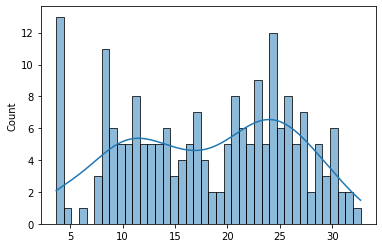

In [45]:
sns.histplot(y_holdout,bins=40,kde=True)

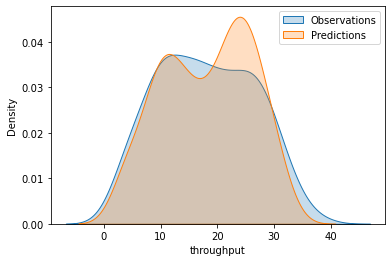

In [46]:
fig,ax = plt.subplots()

sns.kdeplot(y_test, ax=ax, shade=True, label='Observations')
sns.kdeplot(y_holdout, ax=ax,shade=True,label='Predictions')

ax.legend(loc='best')

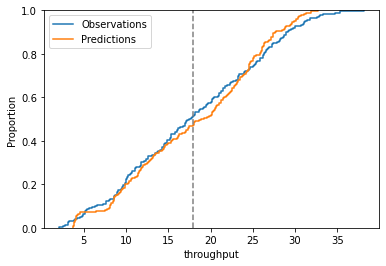

In [47]:
fig,ax = plt.subplots()

sns.ecdfplot(y_test, ax=ax, label='Observations')
sns.ecdfplot(y_holdout, ax=ax,label='Predictions')
plt.axvline(x=y_test.mean(),color='grey',linestyle='--')

ax.legend(loc='best')

In [48]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

mae = mean_absolute_error(y_test,y_holdout)
mse = mean_squared_error(y_test,y_holdout)
rmse = np.sqrt(mse)

In [49]:
err_df = pd.DataFrame(data=[mae, mse, rmse],index=['MAE','MSE','RMSE'],columns=[f'{model_name}'])
err_df

,rf-no
MAE,2.872122
MSE,17.206420
RMSE,4.148062


In [50]:
err_df.to_csv(f'./holdout-test/{model_name}.csv')
# mean_scores.to_csv(f'./opt-model-err/{model_name}-err.csv')

In [51]:
res = y_test - y_holdout
res.describe().drop('count')

mean    -0.212039
std      4.153140
min    -11.139511
25%     -2.061679
50%      0.118501
75%      1.817542
max     20.433812
Name: throughput, dtype: float64

<AxesSubplot:xlabel='throughput', ylabel='Count'>

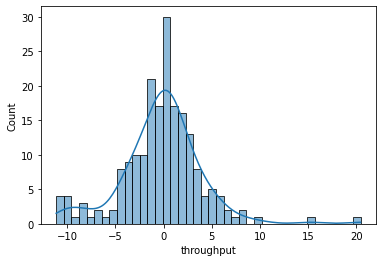

In [52]:
sns.histplot(data=res, kde=True,bins=40)

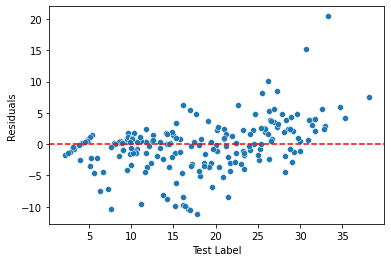

In [53]:
ax = sns.scatterplot(x=y_test, y=res)
ax.set(ylabel='Residuals', xlabel='Test Label')
plt.axhline(y=0,color='red',linestyle='--')

# there should be no clear pattern / curve in the plot
# we see a positive correlation between Test Label and Residuals -> later models should avoid this pattern

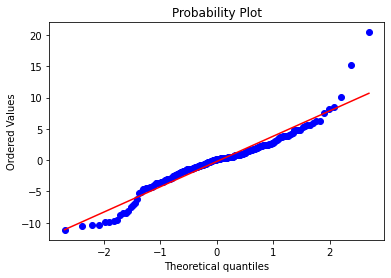

In [54]:
import scipy as sp

fig, ax = plt.subplots()
sp.stats.probplot(res,plot=ax);

# Export Optimized Model

In [55]:
from sklearn.preprocessing import RobustScaler
scaler = RobustScaler()
scaler.fit(X)

RobustScaler()

In [56]:
# MODIFY! 
X = scaler.transform(X)

op_model = score_model

op_model.fit(X,y)

RandomForestRegressor()

In [57]:
y_pred = op_model.predict(X)

<AxesSubplot:ylabel='Count'>

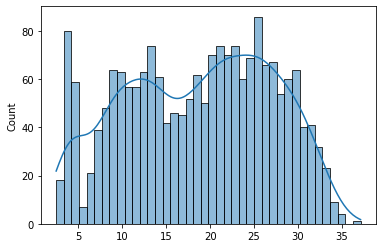

In [58]:
sns.histplot(y_pred,bins=40,kde=True)

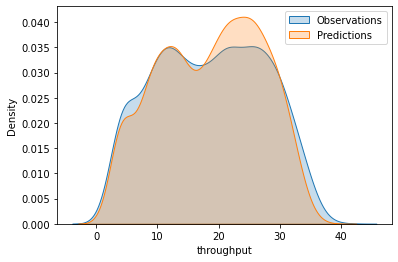

In [59]:
fig,ax = plt.subplots()

sns.kdeplot(y, ax=ax, shade=True, label='Observations')
sns.kdeplot(y_pred, ax=ax,shade=True,label='Predictions')

ax.legend(loc='best')

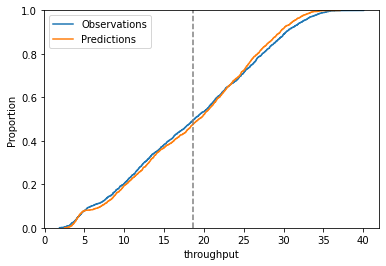

In [60]:
fig,ax = plt.subplots()

sns.ecdfplot(y, ax=ax, label='Observations')
sns.ecdfplot(y_pred, ax=ax,label='Predictions')
plt.axvline(x=y.mean(),color='grey',linestyle='--')

ax.legend(loc='best')

In [61]:
mae = mean_absolute_error(y,y_pred)
mse = mean_squared_error(y,y_pred)
rmse = np.sqrt(mse)

In [62]:
err_df = pd.DataFrame(data=[mae, mse, rmse],index=['MAE','MSE','RMSE'],columns=[f'{model_name}'])
err_df

,rf-no
MAE,1.007010
MSE,1.999398
RMSE,1.414001


In [63]:
err_df.to_csv(f'./model-err/{model_name}.csv')
# mean_scores.to_csv(f'./opt-model-err/{model_name}-err.csv')

In [64]:
from joblib import dump, load
dump(op_model, f'./opt-models/{model_name}.joblib')

['./opt-models/rf-no.joblib']

In [65]:
res = y - y_pred
res.describe().drop('count')

mean   -0.039808
std     1.413799
min    -7.849034
25%    -0.721226
50%     0.003818
75%     0.736970
max     6.777742
Name: throughput, dtype: float64

<AxesSubplot:xlabel='throughput', ylabel='Count'>

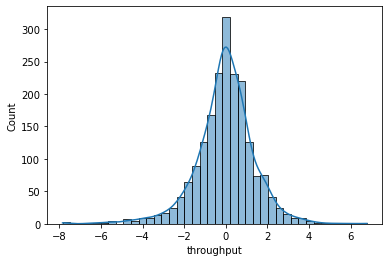

In [66]:
sns.histplot(data=res, kde=True,bins=40)

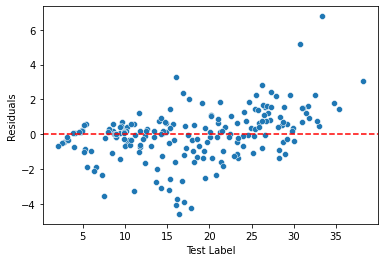

In [67]:
ax = sns.scatterplot(x=y_test, y=res)
ax.set(ylabel='Residuals', xlabel='Test Label')
plt.axhline(y=0,color='red',linestyle='--')

# there should be no clear pattern / curve in the plot
# we see a positive correlation between Test Label and Residuals -> later models should avoid this pattern

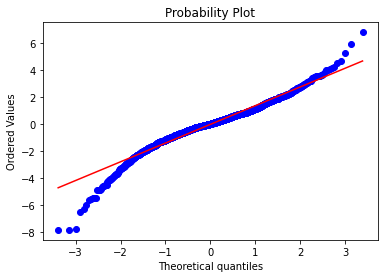

In [68]:
import scipy as sp

fig, ax = plt.subplots()
sp.stats.probplot(res,plot=ax);

DONE!